
<h1 align="center">
  Lava, Lava-DNF and the Loihi Software Ecosystem

</h1>

## Software Ecosystem:

### The relationship between Magma and Lava

<h1 align="center">
<img src="magma_versus_lava.png" 
     width="200" 
     height="250" />
</h1>


### Lava Magma follows a composable coding paradigm.
* Lava architecture "is inspired from the Communicating Sequential Process (CSP) paradigm for asynchronous, parallel systems that interact via message passing." -- Qoute from Lava README.md

### Since Lava is "composable", in theory these older Loihi coding paradigms should be interopable:
* Intel: NxSDK Also known as the Loihi Neurocore API
* SNIPS C code.
* "The specific components of Magma needed to compile processes specifically to Intel Loihi chips remains proprietary to Intel and is not provided through this GitHub site (see below). Similar Magma-layer code for other future commercial neuromorphic platforms likely will also remain proprietary." -- Qoute from Lava README.md

* Warning, this NB needs Python-3.8 minimum


## Loihi

<h1 align="center">
<img src="loihi_diagram.png" 
     width="300" 
     height="450" />
</h1>
     
     
### Lava Dynamic Neural Fields Lava-DNF 
* DNF is the subset of the Lava paradigm that has a lot of useful patterns for specifying biological connectivity. 
* https://github.com/lava-nc/lava-dnf


# Usefulness of Lava-DNF for large scale biological modelling work

#### What we want from an interface

- [x] Means to specify forwards connectivity between populations.
- [x] Means to specify recurrent connectivity between populations.
- [x] Ability to define LIF Cell populations.
- [x] Inhibitory Synapses (negative weight values possible)
- [x] Capacity to support high cell counts.
- [ ] Ability to visualize the whole architecture (nothing like TorchViz for ANN architecture yet).
- [ ] Spike Timing Dependent Plasticity (STDP), or on chip local learning rules (coming).  
- [ ] Delay Learning (probably not even planned)
- [ ] Adaptive Neurons (supported by SLAYER allegedly composable)
- [ ] performance profiling (including power consumption). (coming)



<h1 align="center">
  To show how I established the tick box above a Lava-DNF code demonstration follows.
</h1>


To evaluate whether Lava is useful for making bioplausible models, we want to define a variety of overlapping Spiking Neural Network (SNN) architectures, you can think of each one as a weighted directed graph: 

<h1 align="center">
 $G(V, E)$
</h1>

Below is a diagram of the Potjan's cortical model. This model can be thought of as the composition of many weighted directed graphs, therefore we will use Lava a supported interface to instantiate a cortical model of V1 on a Python Loihi simulator.

<h1 align="center">

<img src="Schematic-diagram-of-the-Potjans-Diesmann-cortical-microcircuit-model.png" 
     width="300" 
     height="350" />
</h1>



## Import relevant modules.

In [1]:
from lava.lib.dnf.operations.operations import Weights
from lava.lib.dnf.operations.operations import *
from lava.proc.lif.process import LIF
from lava.lib.dnf.inputs.rate_code_spike_gen.process import RateCodeSpikeGen
from lava.lib.dnf.connect.connect import connect
from lava.lib.dnf.operations.operations import Weights
from lava.magma.core.run_configs import Loihi1SimCfg #Loihi simulator, not  Loihi itself.
from lava.magma.core.run_conditions import RunSteps
from lava.proc.monitor.process import Monitor
from lava.proc.monitor.models import PyMonitorModel
from lava.lib.dnf.inputs.gauss_pattern.process import GaussPattern
from lava.lib.dnf.kernels.kernels import MultiPeakKernel
from lava.lib.dnf.utils.plotting import raster_plot

import numpy as np


# Cortical Specification:
### These numbers are nominal. 
* I chose the following numbers to fit the performance of a resource limited laptop
* 2 columns.
* 4 layers
* 1 excitatory and 1 inhibitory population per layer.
* 85 cells per population 170 cells per layer.

In [2]:

ncolumns=2



### Create layerwise cell populations 

In [3]:
# Ex excitatory
ly_2_3_ex = np.ndarray((ncolumns),dtype=object)
ly_4_ex = np.ndarray((ncolumns),dtype=object)
ly_5_ex = np.ndarray((ncolumns),dtype=object)
ly_6_ex = np.ndarray((ncolumns),dtype=object)

# In inhibitory
ly_2_3_in = np.ndarray((ncolumns),dtype=object)
ly_4_in = np.ndarray((ncolumns),dtype=object)
ly_5_in = np.ndarray((ncolumns),dtype=object)
ly_6_in = np.ndarray((ncolumns),dtype=object)

ncells = 85
for i in range(0,ncolumns):
    ly_2_3_ex[i] = LIF(shape=(ncells,))
    ly_4_ex[i] = LIF(shape=(ncells,))
    ly_5_ex[i] = LIF(shape=(ncells,))
    ly_6_ex[i] = LIF(shape=(ncells,))


    ly_2_3_in[i] = LIF(shape=(ncells,))
    ly_4_in[i] = LIF(shape=(ncells,))
    ly_5_in[i] = LIF(shape=(ncells,))
    ly_6_in[i] = LIF(shape=(ncells,))

    

<h1 align="center"> Create the connectivity pattern </h1>
<h4 align="center"> 
* Repeated and stereotyped connections whithin and between layers:
</h4>
<!--

<h1 align="center">
    <img src="Schematic-diagram-of-the-Potjans-Diesmann-cortical-microcircuit-model.png" 
         width="300" 
         height="350" />
</h1>

* from the Potjan's wiring diagram
researchgate.net/figure/Schematic-diagram-of-the-Potjans-Diesmann-cortical-microcircuit-model_fig1_349443713

-->

In [4]:

connections=[]
# recurrent
for i in range(0,ncolumns):
    #ly_2_3_ex[i] 2 ly_2_3_ex[i]
    one2onec = connect(ly_2_3_ex[i].s_out, ly_2_3_ex[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_4_ex[i] 2 ly_4_ex[i]            
    one2onec = connect(ly_4_ex[i].s_out, ly_4_ex[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_5_ex[i] 2 ly_5_ex[i]
    one2onec = connect(ly_5_ex[i].s_out, ly_5_ex[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_6_ex[i] 2 ly_6_ex[i]
    one2onec = connect(ly_6_ex[i].s_out, ly_6_ex[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)



In [5]:
for i in range(0,ncolumns):
    #ly_2_3_in[i] 2 ly_2_3_in[i]
    one2onec = connect(ly_2_3_in[i].s_out, ly_2_3_in[i].a_in, ops=[Weights(-0.5)])
    connections.append(one2onec)

    #ly_4_in[i] 2 ly_4_in[i]
    one2onec = connect(ly_4_in[i].s_out, ly_4_in[i].a_in, ops=[Weights(-0.5)])
    connections.append(one2onec)

    #ly_5_in[i] 2 ly_5_in[i]
    one2onec = connect(ly_5_in[i].s_out, ly_5_in[i].a_in, ops=[Weights(-0.5)])
    connections.append(one2onec)

    #ly_6_in[i] 2 ly_6_in[i]
    one2onec = connect(ly_6_in[i].s_out, ly_6_in[i].a_in, ops=[Weights(-0.5)])
    connections.append(one2onec)

for i in range(0,ncolumns):

    #ly_2_3_ex[i] 2 ly_2_3_in[i]
    one2onec = connect(ly_2_3_ex[i].s_out, ly_2_3_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_4_ex[i] 2 ly_4_in[i]
    one2onec = connect(ly_4_ex[i].s_out, ly_4_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_5_ex[i] 2 ly_5_in[i]
    one2onec = connect(ly_5_ex[i].s_out, ly_5_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_6_ex[i] 2 ly_6_in[i]
    one2onec = connect(ly_6_ex[i].s_out, ly_6_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

for i in range(0,ncolumns):
    #ly_2_3_in[i] 2 ly_2_3_exc[i]
    # ly_2_3_ex
    one2onec = connect(ly_2_3_in[i].s_out, ly_2_3_ex[i].a_in, ops=[Weights(-1.0)])
    connections.append(one2onec)

    #ly_4_in[i] 2 ly_4_exc[i]
    one2onec = connect(ly_4_in[i].s_out, ly_4_ex[i].a_in, ops=[Weights(-1.0)])
    connections.append(one2onec)

    #ly_5_in[i] 2 ly_5_exc[i]
    one2onec = connect(ly_5_in[i].s_out, ly_5_ex[i].a_in, ops=[Weights(-1.0)])
    connections.append(one2onec)
    
    #ly_6_in[i] 2 ly_6_exc[i]
    one2onec = connect(ly_6_in[i].s_out, ly_6_ex[i].a_in, ops=[Weights(-1.0)])
    connections.append(one2onec)


### Very specific connections between layer connections:

In [6]:
for i in range(0,ncolumns):
    one2onec = connect(ly_2_3_ex[i].s_out, ly_5_ex[i].s_out, ops=[Weights(1.0)])
    connections.append(one2onec)

    one2onec = connect(ly_2_3_ex[i].s_out, ly_4_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    one2onec = connect(ly_2_3_ex[i].s_out, ly_5_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)


In [7]:
for i in range(0,ncolumns):

    one2onec = connect(ly_5_ex[i].s_out, ly_4_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    one2onec = connect(ly_6_ex[i].s_out, ly_4_ex[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    one2onec = connect(ly_6_ex[i].s_out, ly_2_3_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)


In [8]:

for i in range(0,ncolumns):

    one2onec = connect(ly_2_3_ex[i].s_out, ly_2_3_in[i].a_in, ops=[Weights(-0.5)])
    connections.append(one2onec)

In [9]:
for i in range(0,ncolumns):

    one2onec = connect(ly_4_ex[i].s_out, ly_2_3_ex[i].s_out, ops=[Weights(1.0)])
    connections.append(one2onec)

    one2onec = connect(ly_4_ex[i].s_out, ly_5_ex[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    one2onec = connect(ly_5_ex[i].s_out, ly_6_ex[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

Specify a direct connection between each of the two columns as a demonstration only
layer 2-3 of Column2 (index 1) gets no tonic input, its input is just the output of column 1 (index 0)
ly_2_3_ex[1]


In [10]:
one2onec = connect(ly_2_3_ex[0].s_out, ly_2_3_ex[1].s_out, ops=[Weights(5.0)])
connections.append(one2onec)

* Despite the elaborate wiring instructions. The wiring itself is still flawed.
* Currently the network has no convergence or divergence between or across layers, so its not so much a network, and more of a series of parallel feedforward lines, like in the figure below:

<h1 align="center">
    <img src="one_to_one_connectivity.png" 
         width="90" 
         height="40"/>
</h1>

# TODO:

- [ ] Use the OSB PyNN model to wire layer to layer connections with established probabilities from Potjan's.
https://github.com/NeuralEnsemble/PyNN/blob/master/examples/Potjans2014/network.py




# Create tonic input for the network.

In [11]:
spike_generator_1 = RateCodeSpikeGen(shape=ncells,)
center_cell=ncells/2.0
spread_across_number_of_cells=ncells 
gauss_pattern_1 = GaussPattern(shape=ncells,
                               amplitude=100,
                               mean=center_cell,
                               stddev=spread_across_number_of_cells)
gauss_pattern_1.a_out.connect(spike_generator_1.a_in)

for i in range(0,ncolumns):
    _=connect(spike_generator_1.s_out, ly_4_ex[i].a_in, [Weights(2.5)])


# Run the preliminary Potjans model on CPU for 50ms

Strangely you only have to run a segment of the model to run the whole model.

Model segments seem to have parent child relationships with other segments if they are connected with network connections, and the Loihi compiler seems to understand that.

# Set up the experimental recording rig

In [12]:

time_steps = 50

monitor_ly_2_3_ex = Monitor()
monitor_ly_2_3_ex.probe(target=ly_2_3_ex[0].s_out, num_steps=time_steps)
monitor_ly_2_3_in = Monitor()
monitor_ly_2_3_in.probe(target=ly_2_3_in[0].s_out, num_steps=time_steps)
monitor_ly_4_ex = Monitor()
monitor_ly_4_ex.probe(target=ly_4_ex[0].s_out, num_steps=time_steps)
monitor_input_1 = Monitor()
monitor_input_1.probe(spike_generator_1.s_out, time_steps)
other_column = Monitor()
other_column.probe(ly_2_3_ex[1].s_out, time_steps)



ly_4_ex[0].amplitude = 100
ly_4_ex[0].run(condition=RunSteps(num_steps=time_steps),
        run_cfg=Loihi1SimCfg(select_tag='floating_pt'))




# Get probed data from monitors


In [13]:

data_input1 = monitor_input_1.get_data()\
    [spike_generator_1.name][spike_generator_1.s_out.name]

data_ly_2_3_ex = monitor_ly_2_3_ex.get_data()\
    [ly_2_3_ex[0].name][ly_2_3_ex[0].s_out.name]

data_ly_2_3_in = monitor_ly_2_3_in.get_data()\
    [ly_2_3_in[0].name][ly_2_3_in[0].s_out.name]


data_ly_4_ex = monitor_ly_4_ex.get_data()\
    [ly_4_ex[0].name][ly_4_ex[0].s_out.name]



### Plot the Spiking Data

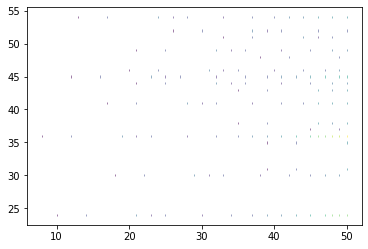

In [14]:



raster_plot(data_ly_2_3_ex.T)


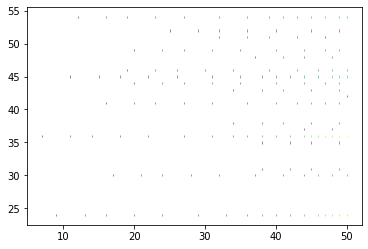

In [15]:

raster_plot(data_ly_4_ex.T)


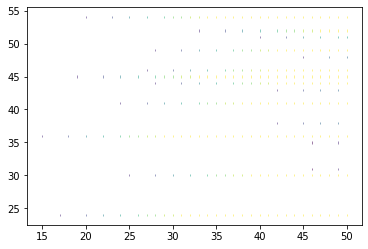

In [16]:
raster_plot(data_ly_2_3_in.T)


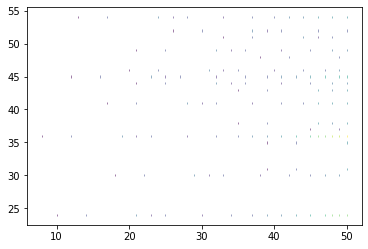

In [17]:
raster_plot(data_ly_2_3_ex.T)

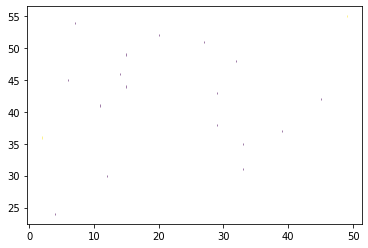

In [18]:

raster_plot(data_input1.T)



* Check to see spiking activity propogated from one column to the other via a dedicated connection

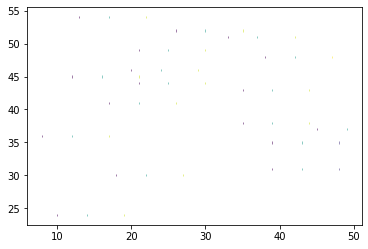

In [19]:
data_ly_2_3_ex = other_column.get_data()\
    [ly_2_3_ex[1].name][ly_2_3_ex[1].s_out.name]


raster_plot(data_ly_2_3_ex.T)


### My verdict the overall approach works for some things but not others.

- [x] Fan in and fan out achievable with connection kernels.
- [x] Mexican hat weight distributions (lateral inhibition) can be coded.
- [x] Means to specify forwards connectivity between populations.
- [x] Means to specify recurrent connectivity between populations.
- [x] Ability to define LIF Cell populations.
- [x] Inhibitory Synapses (negative weight values possible)
- [x] Capacity to support high cell counts.

### Missing
- [ ] Although Lava is advertised as composable (interopable with external code) it's unlikely that an arbitrary model of STDP can be translated through the Loihi compiler.
- [ ] It's not clear how composable the LAVA approach is with NxSDK and SNIPs (without breaking Loihi compilation).
- [ ] Loihi compilation is still intentionally opaque (proprietary code).
- [ ] Ability to visualize the whole architecture (nothing like TorchViz for ANN architecture yet).
- [ ] Delay Learning (probably not even planned)
- [ ] performance profiling (including power consumption). (coming)
- [ ] No synaptic learning capability yet. 
    
    *... and It's not clear how to hack STDP in.


